$
\newcommand{\ud}{\, \text{d}}
$

## Learning a Gaussian with FML : - )

In [1]:
import os
import sys
import time

import numpy as np
import tensorflow as tf


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True

sess = tf.Session(config=config)

In [2]:
class flags:
    
    dim = 1
    
    # optimization
    learning_rate = 1e-3 # Base learning rate
    lr_decay = 0.999995 # Learning rate decay, applied every step of the optimization
    
    batch_size = 128 # Batch size during training per GPU
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [3]:
def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(n_samples/args.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*args.batch_size
        ed = min((mloop+1)*args.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        # print([st,ed])
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/args.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*args.batch_size
        ed = min((mloop+1)*args.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [4]:


def tf_gauss_logpdf(x,mu=0.,sig2=1.):
    
    return -tf.square(x-mu)/(2.*sig2)-.5*tf.log(2.*np.pi*sig2)

def tf_unnorm_gauss_logpdf(x,mu=0.,sig2=1.):
    
    return -tf.square(x-mu)/(2.*sig2)


def tf_unif_sampler(n_samples,a=0.,b=1.):
    
    return a+(b-a)*tf.random_uniform([n_samples,])

In [5]:
mu_0 = -1.
sig2_0 = 2.25

a_0 = -5.
b_0 = 5.

n_samples = 1000
# x_train = np.random.randn(n_samples,1)
# xx,_ = gauss_sampler_n_logpdf(n_samples,mu=mu_0,sig2=sig2_0)

x_train = mu_0 + np.sqrt(sig2_0)*np.random.randn(n_samples,1)

In [6]:
input_ind = tf.placeholder(tf.int32, shape=[FLAGS.batch_size])
input_x = tf.placeholder(tf.float32, shape=[FLAGS.batch_size,FLAGS.dim])


with tf.variable_scope('model',reuse=tf.AUTO_REUSE):
    embeddings = tf.get_variable('embeddings',shape=[n_samples,1])
    mu = tf.get_variable('mu',shape=[1,])
    logsig2 = tf.get_variable('logsig2',shape=[1,])
    
sig2 = tf.exp(logsig2)

psi = lambda x: -tf_unnorm_gauss_logpdf(x, mu=mu, sig2=sig2)

    
u_params = embeddings
psi_params = [mu,logsig2]

u_x = tf.nn.embedding_lookup(embeddings, input_ind)

prop_q = tf_unif_sampler(FLAGS.batch_size,a=a_0,b=b_0)


psi_x = psi(input_x)
psi_q = psi(prop_q)

I_x = tf.exp(psi_x - psi_q)*(b_0-a_0)  # volume of the integral must be accounted for

loss = tf.reduce_mean(-u_x-tf.exp(-u_x)*I_x)

In [7]:
learning_rate = tf.placeholder(tf.float32)

u_learning_rate = learning_rate
u_optimizer = tf.train.AdamOptimizer(u_learning_rate)
train_u = u_optimizer.minimize(-loss,var_list=u_params)

psi_learning_rate = 1e-1*learning_rate
psi_optimizer = tf.train.AdamOptimizer(psi_learning_rate)
# train_psi = psi_optimizer.minimize(loss, var_list=psi_params)
train_psi = psi_optimizer.minimize(-loss, var_list=psi_params)

In [8]:
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [9]:
true_logp_x = tf_gauss_logpdf(input_x, mu=mu_0, sig2=sig2_0)

true_mdl_logp_x = tf_gauss_logpdf(input_x, mu=mu, sig2=sig2)

In [10]:
inds = np.array(range(FLAGS.batch_size))
xx = x_train[inds]

ii = 0

print('Ground Truth: %.2f' % sess.run(true_mdl_logp_x,{input_x:xx})[ii])
print('Current Estimate: %.2f' % -sess.run(u_x, {input_ind:inds})[ii])

Ground Truth: -0.63
Current Estimate: -0.04


In [11]:
_ = sess.run([tf.assign(mu,[1.]),tf.assign(logsig2,np.log([1.44]))])

In [12]:
mu_val, sig2_val = sess.run([mu,sig2])

print('Ground Truth: N(%.2f, %.2f), Model: N(%.2f, %.2f)' % \
     (mu_0, sig2_0, mu_val, sig2_val))

Ground Truth: N(-1.00, 2.25), Model: N(1.00, 1.44)


Mean Abs Error: 3.10
Mean Abs Error: 2.98
Mean Abs Error: 2.93
Mean Abs Error: 2.57
Mean Abs Error: 2.55
Mean Abs Error: 2.36
Mean Abs Error: 2.15
Mean Abs Error: 2.28
Mean Abs Error: 2.06
Mean Abs Error: 2.04
Mean Abs Error: 2.07
Mean Abs Error: 1.67
Mean Abs Error: 1.63
Mean Abs Error: 1.59
Mean Abs Error: 1.47
Mean Abs Error: 1.77
Mean Abs Error: 1.16
Mean Abs Error: 1.20
Mean Abs Error: 1.32
Mean Abs Error: 1.28


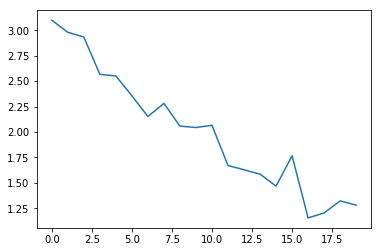

In [13]:
# Estimating likelihood

lr = 1e-3

max_updates = 500
num_iter = 20

loss_record = []

for iterId in range(num_iter):
    
    for step in range(max_updates):
        
        inds = np.random.choice(n_samples,FLAGS.batch_size)
        xx = x_train[inds]
        
        _ = sess.run(train_u,{input_x: xx, input_ind:inds, learning_rate: lr})
        
    ii = 0
    
    # inds = np.array(range(FLAGS.batch_size))
    inds = np.random.choice(n_samples,FLAGS.batch_size)
    xx = x_train[inds]
    true_logp_xx = sess.run(true_mdl_logp_x,{input_x:xx})
    est_logp_xx = -sess.run(u_x, {input_ind:inds})
    mean_abs_err = np.mean(np.abs(true_logp_xx-est_logp_xx))
    print('Mean Abs Error: %.2f' % mean_abs_err)
    
    loss_record.append(mean_abs_err)
    
_ = plt.plot(loss_record)

Mean Abs Error: 0.68
Ground Truth: N(-1.00, 2.25), Model: N(0.94, 1.53)


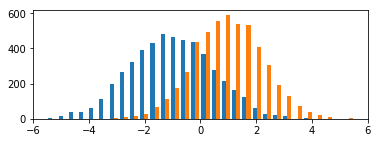

Mean Abs Error: 0.72
Ground Truth: N(-1.00, 2.25), Model: N(0.91, 1.57)
Mean Abs Error: 0.53
Ground Truth: N(-1.00, 2.25), Model: N(0.88, 1.61)
Mean Abs Error: 0.45
Ground Truth: N(-1.00, 2.25), Model: N(0.86, 1.65)
Mean Abs Error: 0.40
Ground Truth: N(-1.00, 2.25), Model: N(0.84, 1.68)


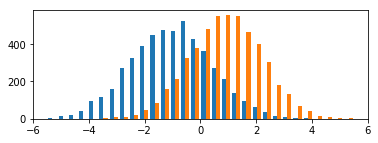

Mean Abs Error: 0.36
Ground Truth: N(-1.00, 2.25), Model: N(0.82, 1.70)
Mean Abs Error: 0.45
Ground Truth: N(-1.00, 2.25), Model: N(0.81, 1.73)
Mean Abs Error: 0.37
Ground Truth: N(-1.00, 2.25), Model: N(0.79, 1.76)
Mean Abs Error: 0.39
Ground Truth: N(-1.00, 2.25), Model: N(0.77, 1.78)
Mean Abs Error: 0.19
Ground Truth: N(-1.00, 2.25), Model: N(0.76, 1.81)


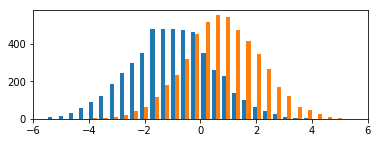

Mean Abs Error: 0.29
Ground Truth: N(-1.00, 2.25), Model: N(0.74, 1.84)
Mean Abs Error: 0.16
Ground Truth: N(-1.00, 2.25), Model: N(0.72, 1.86)
Mean Abs Error: 0.33
Ground Truth: N(-1.00, 2.25), Model: N(0.71, 1.89)
Mean Abs Error: 0.17
Ground Truth: N(-1.00, 2.25), Model: N(0.69, 1.91)
Mean Abs Error: 0.08
Ground Truth: N(-1.00, 2.25), Model: N(0.68, 1.94)


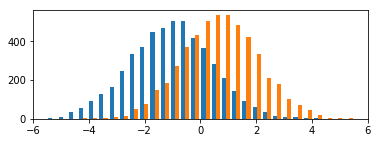

Mean Abs Error: 0.13
Ground Truth: N(-1.00, 2.25), Model: N(0.66, 1.96)
Mean Abs Error: 0.14
Ground Truth: N(-1.00, 2.25), Model: N(0.65, 1.99)
Mean Abs Error: 0.10
Ground Truth: N(-1.00, 2.25), Model: N(0.63, 2.02)
Mean Abs Error: 0.13
Ground Truth: N(-1.00, 2.25), Model: N(0.61, 2.04)
Mean Abs Error: 0.08
Ground Truth: N(-1.00, 2.25), Model: N(0.60, 2.07)


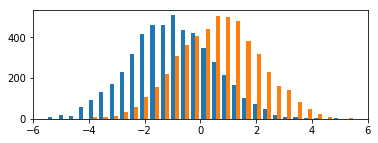

Mean Abs Error: 0.19
Ground Truth: N(-1.00, 2.25), Model: N(0.58, 2.10)
Mean Abs Error: 0.07
Ground Truth: N(-1.00, 2.25), Model: N(0.56, 2.13)
Mean Abs Error: 0.06
Ground Truth: N(-1.00, 2.25), Model: N(0.54, 2.16)
Mean Abs Error: 0.03
Ground Truth: N(-1.00, 2.25), Model: N(0.52, 2.19)
Mean Abs Error: 0.09
Ground Truth: N(-1.00, 2.25), Model: N(0.50, 2.22)


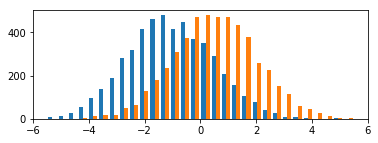

Mean Abs Error: 0.07
Ground Truth: N(-1.00, 2.25), Model: N(0.47, 2.25)
Mean Abs Error: 0.05
Ground Truth: N(-1.00, 2.25), Model: N(0.45, 2.28)
Mean Abs Error: 0.06
Ground Truth: N(-1.00, 2.25), Model: N(0.42, 2.32)
Mean Abs Error: 0.08
Ground Truth: N(-1.00, 2.25), Model: N(0.38, 2.35)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(0.35, 2.39)


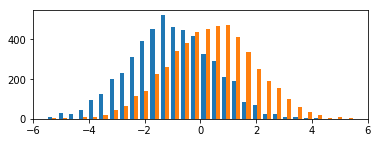

Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(0.31, 2.43)
Mean Abs Error: 0.03
Ground Truth: N(-1.00, 2.25), Model: N(0.26, 2.46)
Mean Abs Error: 0.03
Ground Truth: N(-1.00, 2.25), Model: N(0.21, 2.50)
Mean Abs Error: 0.04
Ground Truth: N(-1.00, 2.25), Model: N(0.15, 2.54)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(0.09, 2.58)


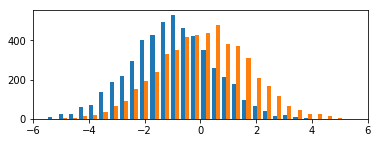

Mean Abs Error: 0.03
Ground Truth: N(-1.00, 2.25), Model: N(0.02, 2.61)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.06, 2.64)
Mean Abs Error: 0.03
Ground Truth: N(-1.00, 2.25), Model: N(-0.14, 2.66)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.22, 2.68)
Mean Abs Error: 0.04
Ground Truth: N(-1.00, 2.25), Model: N(-0.31, 2.69)


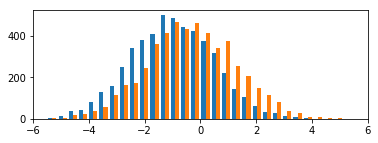

Mean Abs Error: 0.01
Ground Truth: N(-1.00, 2.25), Model: N(-0.40, 2.68)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.49, 2.66)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.57, 2.61)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.66, 2.56)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.73, 2.49)


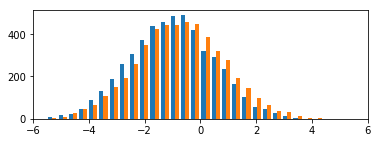

Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.80, 2.42)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.86, 2.36)
Mean Abs Error: 0.03
Ground Truth: N(-1.00, 2.25), Model: N(-0.91, 2.30)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.94, 2.28)
Mean Abs Error: 0.02
Ground Truth: N(-1.00, 2.25), Model: N(-0.96, 2.26)


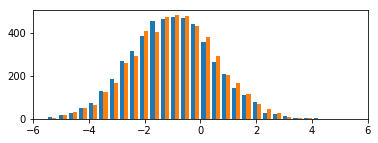

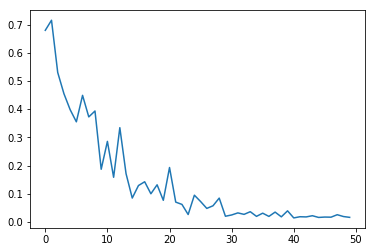

In [14]:
# Maximizing likelihood

lr = 3e-3
max_updates = 500
num_iter = 50



loss_record = []

for iterId in range(num_iter):
    
    for step in range(max_updates):
        
        inds = np.random.choice(n_samples,FLAGS.batch_size)
        xx = x_train[inds]
        
        # _ = sess.run(train_u,{input_x: xx, input_ind:inds, learning_rate: lr})
        _,_ = sess.run([train_u, train_psi],{input_x: xx, input_ind:inds, learning_rate: lr})
        
    # ii = np.random.choice()
    ii = 0
    
    # inds = np.array(range(FLAGS.batch_size))
    inds = np.random.choice(n_samples,FLAGS.batch_size)
    xx = x_train[inds]
    true_logp_xx = sess.run(true_mdl_logp_x,{input_x:xx})
    est_logp_xx = -sess.run(u_x, {input_ind:inds})
    mean_abs_err = np.mean(np.abs(true_logp_xx-est_logp_xx))
    print('Mean Abs Error: %.2f' % mean_abs_err)
    
    mu_val, sig2_val = sess.run([mu,sig2])

    print('Ground Truth: N(%.2f, %.2f), Model: N(%.2f, %.2f)' % \
         (mu_0, sig2_0, mu_val, sig2_val))
    
    if (iterId+1)%5==0 or iterId==0:
        
        _ = plt.figure(figsize=(6,2))
    
        m_samples = 5000
        true_samples = mu_0 + np.sqrt(sig2_0)*np.random.randn(m_samples,)
        mdl_samples = mu_val + np.sqrt(sig2_val)*np.random.randn(m_samples,)
        _ = plt.hist([true_samples,mdl_samples],range=[-5.5,5.5],bins=30)

        _ = plt.show()
    
    loss_record.append(mean_abs_err)
    
_ = plt.plot(loss_record)